In [1]:
%pylab inline
import numpy as np
import yaml
from scipy.interpolate import interp1d
from scipy.optimize import leastsq

Populating the interactive namespace from numpy and matplotlib


In [111]:

def load_yaml(fname):
    with open(fname, 'r') as file:
        data = yaml.safe_load(file)
    return data

def compute_normalized_force_response(device_force_values, MVC, forceRangeMin=0.05, forceRangeMax=0.30, clamp=None):
    """
    Convert from sensor values to heigt values that were used in the display for direct comparison to the target sequence. Works fine for any array.
    ((deviceForceValue / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)

    MVC:            maximumum voluntary contraction of this individual (in original device units)
    clamp:          list of min/max values to clamp any values that are above or below to, default = None (no clamping)
    """

    norm_resp = ((device_force_values / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)
    if clamp is not None:
        norm_resp[norm_resp<clamp[0]] = clamp[0]
        norm_resp[norm_resp>clamp[1]] = clamp[1]
    return norm_resp

def lag_calc(yy,yy_shifted):
    #easy way, with max res of 1 unit of time
    #returns positive value for lag (i.e., yy_shifted occurs after yy in time)
    from scipy import signal
    
    xcorr = signal.correlate(yy,yy_shifted,mode='full')
    lags = signal.correlation_lags(yy.size,yy_shifted.size,mode='full')
    lag = lags[np.argmax(xcorr)]
    return lag*-1

def lag_calc_ms(for_time,ref_vals_interp,for_vals):
    """
    Based on least squares version
    """
        # # compute temporal lag
    def err_func(p):
        return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate")(for_time[1:-1]+p[0]) - for_vals[1:-1]

    p0 = [0,] # Inital guess of no shift
    found_shift = leastsq(err_func,p0)[0][0]
    return found_shift*-1 #positive values are greater lag (i.e., response after reference)

In [13]:
#load the yaml data, assign block presentation data and device response data
data = load_yaml('./testing/Isa3_Test_Right_Only_out-file.txt')
blocks = data['blocks']
device_idx = 0
for_resp = data['devices'][device_idx]

In [32]:
len(blocks[block_idx]['trials'])

3

median interval time: 11.78 ms
std interval time   : 0.61 ms
lag                 : 188.55 ms
lag (lstsq)         : 82.44

median interval time: 11.78 ms
std interval time   : 0.62 ms
lag                 : 200.31 ms
lag (lstsq)         : 138.20

median interval time: 11.78 ms
std interval time   : 0.65 ms
lag                 : 70.70 ms
lag (lstsq)         : 111.17

median interval time: 11.78 ms
std interval time   : 0.62 ms
lag                 : 200.32 ms
lag (lstsq)         : 81.84

median interval time: 11.78 ms
std interval time   : 0.64 ms
lag                 : 141.39 ms
lag (lstsq)         : 129.76

median interval time: 11.78 ms
std interval time   : 0.65 ms
lag                 : 153.17 ms
lag (lstsq)         : 101.59



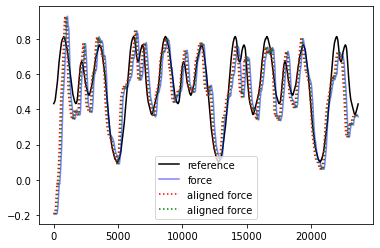

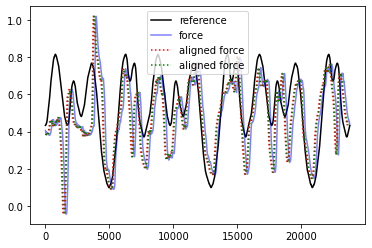

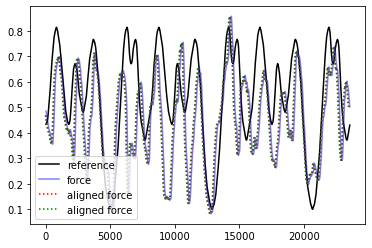

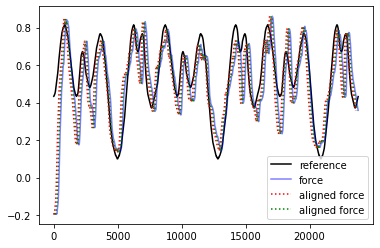

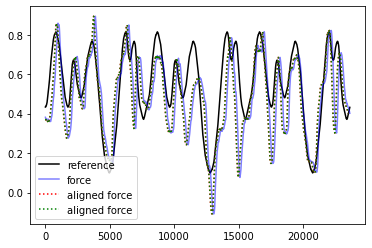

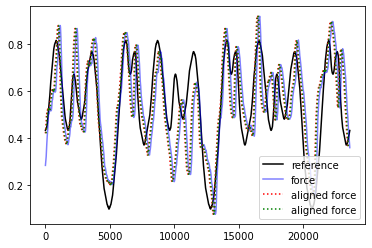

In [125]:

# input data 1st block 1st trial (left): blocks[0]['trials'][0]['leftReference']
#       times,values
#block start time @ startTimestamp, end @ endTimestamp

## loop over each block
block_idx = 0
## loop over each trial
trial_idx = 0

MVC = data['maximumLeftVoluntaryContraction']
#all times and values from the device over the course of the experiment, stored as single vectors
for_time_all = np.array(for_resp['times'])
for_vals_all = compute_normalized_force_response(np.array(for_resp['values']),MVC) #convert to normalized value for comparison

for block_idx in np.arange(len(blocks)):
    for trial_idx in np.arange(len(blocks[block_idx]['trials'])):

        ref_time = np.array(blocks[block_idx]['trials'][trial_idx]['leftReference']['times'])
        ref_vals = np.array(blocks[block_idx]['trials'][trial_idx]['leftReference']['values'])

        start = ref_time[0]
        end = ref_time[-1]

        # compute mask of data in for response vector associated with this specific trial, select time/vals
        for_trial_mask = (for_time_all-start >= 0) & (for_time_all-end<=0) 
        for_time = for_time_all[for_trial_mask]
        for_vals = for_vals_all[for_trial_mask]

        # bring ref vals into the same time space by interpolating, for direct comparison
        # then compute lag and other metrics, also shift by lag and compute metrics again
        # times are in ms, and we use the median time per interval for the conversion of lag (in timestep units) to ms
        ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly
        trial_lag_xcorr = lag_calc(ref_vals_interp,for_vals) #in samples
        time_per_interval = np.median(np.diff(for_time)) #time, in ms
        time_std_per_interval = np.std(np.diff(for_time)) #time, in ms
        trial_lag_xcorr_ms = trial_lag_xcorr*time_per_interval
        for_time = for_time - for_time[0] #zero time so that our plots start at 0
        trial_lag_ms = lag_calc_ms(for_time,ref_vals_interp,for_vals) #alternative way, not sure if this is correct in the end
        # print(trial_lag_ms)
        
        # raw RMSE and SSE
        trial_rmse = np.sqrt(np.mean((ref_vals_interp-for_vals)**2)) #root mean squared error
        trial_sse = ((ref_vals_interp-for_vals)**2).sum()


        # we now take the aligned vectors, snip the parts that we do not have data for, and compare to compute our lag-aligned version
        if trial_lag_xcorr >=0: #we have a lag (i.e., the force comes after the reference)
            snipped_for_vals = for_vals[trial_lag_xcorr:]
            snipped_ref_vals = ref_vals_interp[0:trial_lag_xcorr*-1]
            snipped_for_time = for_time[trial_lag_xcorr:]
        elif trial_lag_xcorr <0: #force preceded the reference
            snipped_for_vals = for_vals[0:trial_lag_xcorr*-1]
            snipped_ref_vals = ref_vals_interp[trial_lag_xcorr:]
            snipped_for_time = for_time[0:trial_lag_xcorr*-1]

        # proportion of elements used to compute RMSE and SSE
        trial_prop_good_els = snipped_for_vals.shape[0] / for_vals.shape[0] 
        # lag-algined RMSE and SSE
        lag_aligned_trial_rmse = np.sqrt(np.mean((snipped_ref_vals-snipped_for_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
        lag_aligned_trial_sse = ((snipped_ref_vals-snipped_for_vals)**2).sum()
        
        # print(f'Block {block_idx} - Trial {trial_idx}')
        print(f'median interval time: {time_per_interval:.2f} ms')
        print(f'std interval time   : {time_std_per_interval:.2f} ms')
        # print(f'lag (time steps)    : {trial_lag_xcorr}')
        print(f'lag                 : {trial_lag_xcorr_ms:.2f} ms')
        print(f'lag (lstsq)         : {trial_lag_ms:.2f}')
        # print(f'rmse                : {trial_rmse:.2f} ms')
        # print(f'sse                 : {trial_sse:.2f} ms')
        # print(f'lag-aligned rmse    : {lag_aligned_trial_rmse:.2f} ms')
        # print(f'lag-aligned sse     : {lag_aligned_trial_sse:.2f} ms')
        # print(f'prop good elelements: {trial_prop_good_els:.2f}')
        print("")

        plt.figure()
        plt.plot(for_time,ref_vals_interp,'k-',label='reference')
        plt.plot(for_time,for_vals,'b-',alpha=0.5, label='force')
        # plt.plot(snipped_for_time,snipped_ref_vals,'k-',label='reference')
        plt.plot(snipped_for_time-trial_lag_xcorr_ms,snipped_for_vals,'r:',label='aligned force')
        plt.plot(snipped_for_time-trial_lag_ms,snipped_for_vals,'g:',label='aligned force')
        
        # plt.text(f'lag {trial_lag_xcorr_ms:.2f} ms')
        plt.legend()


In [114]:
trial_lag_ms

82.44301786770032

(0.0, 4000.0)

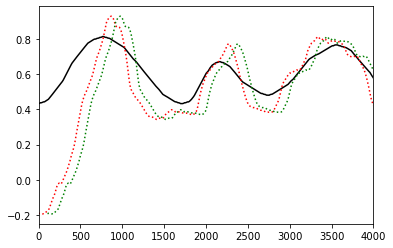

In [116]:
plt.figure()
plt.plot(for_time,ref_vals_interp,'k-',label='reference')
# plt.plot(for_time,for_vals,'b-',alpha=0.5, label='force')
# plt.plot(snipped_for_time,snipped_ref_vals,'k-',label='reference')
plt.plot(snipped_for_time-trial_lag_xcorr_ms,snipped_for_vals,'r:',label='aligned force')
plt.plot(snipped_for_time-trial_lag_ms,snipped_for_vals,'g:',label='aligned force')
plt.xlim(0,4000)

In [109]:
lag_calc_ms(for_time,ref_vals_interp,for_vals)

-82.44301786770032

In [63]:
ref_vals_interp.shape
snipped_ref_vals.shape
snipped_for_time

array([5.87298412e+08, 5.87298423e+08, 5.87298435e+08, ...,
       5.87321874e+08, 5.87321887e+08, 5.87321898e+08])

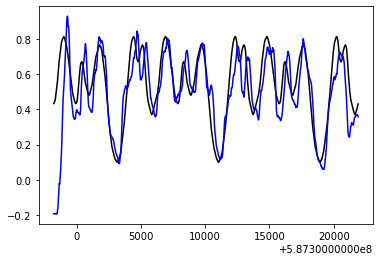

In [45]:
plt.figure()
plt.plot(for_time,ref_vals_interp,'k-',label='reference')
plt.plot(for_time,for_vals,'b-',label='force')
# plt.plot(snipped_for_time,snipped_for_vals,'r-',label='aligned force')

(1995,)
(1995,)


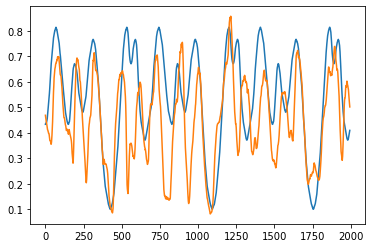

In [18]:


print(snipped_for_vals.shape)
print(snipped_ref_vals.shape)

plt.plot(snipped_ref_vals)
plt.plot(snipped_for_vals)
# for_vals.shape

[0]
[0.]
[0.]
[1.49011612e-08]
[-121.98935654]
[-121.98935472]
[-74.69475903]
[-74.69475792]
[-91.71327781]
[-91.71327781]
[-91.71327781]
[-82.10358687]
[-82.10358565]
[-82.81225896]
[-82.81225896]
[-82.81225896]
[-82.81225896]
[-82.4867231]
[-82.48672187]
[-82.40283754]
[-82.40283754]
[-82.40283754]
[-82.44301787]
[-82.44301664]
[-82.44928763]
-82.44301786770032
16


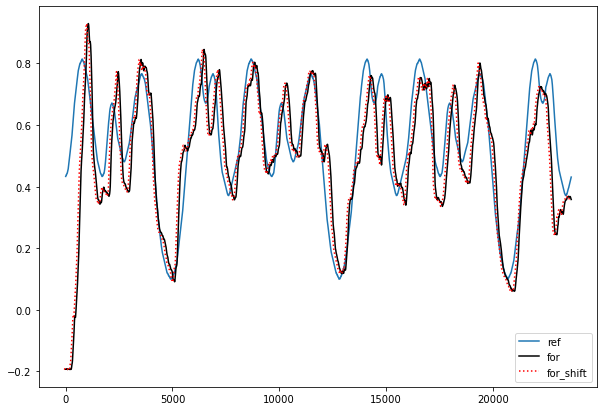

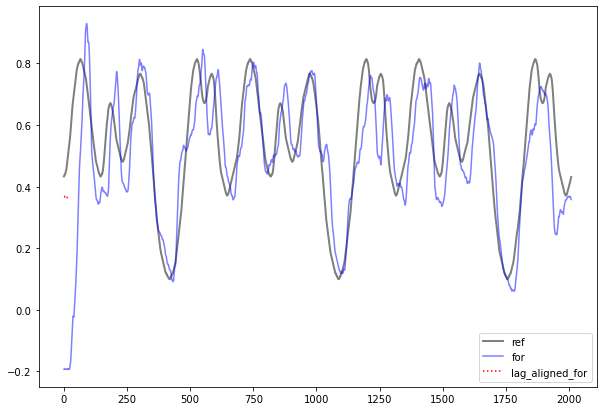

In [72]:
#bring the reference positions into the same time space as the force for direct comparison (linear interp)
# ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly

# # compute temporal lag
def err_func(p):
    print(p)
    return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate")(for_time[1:-1]+p[0]) - for_vals[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]
lag_xcorr = lag_calc(ref_vals_interp,for_vals)
print(found_shift)
print(lag_xcorr)

# lstsq approach
plt.figure(figsize=(10,7))
# plt.plot(ref_time,ref_vals,'.',label='ref_orig')
plt.plot(for_time,ref_vals_interp,label='ref')
plt.plot(for_time,for_vals,'k-',label='for')
plt.plot(for_time+found_shift,for_vals,'r:',label='for_shift')
plt.legend()

plt.figure(figsize=(10,7)) #xcorr approach
plt.plot(ref_vals_interp,'k-',linewidth=2,label='ref',alpha=0.5)
plt.plot(for_vals,'b-',label='for',alpha=0.5)
plt.plot(for_vals[lag_xcorr*-1:],'r:',label='lag_aligned_for')
plt.legend()